In [1]:
!nvidia-smi

Fri Jan  3 20:33:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install sentencepiece

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Imports

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, getActiveUnits, print_generative_reconstruction, pad_token_array, get_latent_rep_of_sentence, deterministic_generate_sentence_from_latent, generate_sentence_from_latent

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and model

Small

In [6]:
"""
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
print("FR part")
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")
"""

'\ndata_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))\ntraining_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]\ntest_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]\nprint("FR part")\nprint(f"train formal len: {len(data_dict[\'train\'][\'formal\'])}")\nprint(f"train informal len: {len(data_dict[\'train\'][\'informal\'])}")\nprint(f"test formal len: {len(data_dict[\'test\'][\'formal\'])}")\nprint(f"test informal len: {len(data_dict[\'test\'][\'informal\'])}")\nprint("\nData sizes")\nprint(f"training data len: {len(training_data)}")\nprint(f"test data len: {len(test_data)}")\n'

Large

In [7]:
data_dict = pickle.load(open(root_path + "FREM_data_set_sub10.p", "rb"))
training_data = data_dict["FR"]["train"]["formal"] + data_dict["FR"]["train"]["informal"] + data_dict["EM"]["train"]["formal"] + data_dict["EM"]["train"]["informal"]
test_data = data_dict["FR"]["test"]["formal"] + data_dict["FR"]["test"]["informal"] + data_dict["EM"]["test"]["formal"] + data_dict["EM"]["test"]["informal"] 
print("EM part")
print(f"train formal len: {len(data_dict['EM']['train']['formal'])}")
print(f"train informal len: {len(data_dict['EM']['train']['informal'])}")
print(f"test formal len: {len(data_dict['EM']['test']['formal'])}")
print(f"test informal len: {len(data_dict['EM']['test']['informal'])}")
print("\nFR part")
print(f"train formal len: {len(data_dict['FR']['train']['formal'])}")
print(f"train informal len: {len(data_dict['FR']['train']['informal'])}")
print(f"test formal len: {len(data_dict['FR']['test']['formal'])}")
print(f"test informal len: {len(data_dict['FR']['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")

EM part
train formal len: 14557
train informal len: 14557
test formal len: 719
test informal len: 719

FR part
train formal len: 13083
train informal len: 13083
test formal len: 606
test informal len: 606

Data sizes
training data len: 55280
test data len: 2650


In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)

#small
#sp = spm.SentencePieceProcessor()
#sp.Load(root_path + 'FRtraintest16000.model')
#VOCAB_SIZE = 16000

#large
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'fulltraintest32000.model')
VOCAB_SIZE = 32000

Small

In [0]:
BATCH_SIZE = 2048
from torch.utils.data import DataLoader

train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data_loader = DataLoader(test_data, batch_size=len(test_data))



In [10]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p=WORD_DROPOUT_P).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "FB_CA_WD_RNN_VAE_large.pt"))

<All keys matched successfully>

## Results

#### Qualitative results

In [11]:
print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=0, train_data_loader=train_data_loader)

Real sentence: she cannot take care of the first.
Generated sentence: she claimed to have seen in fairy.



In [12]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: why do you still speak to her?
Generated sentence: why do you not mind want that?

*******
Real sentence: don't eat too much ice cream.
Generated sentence: don't worry about simply a male.

*******
Real sentence: should i telll her i like him?
Generated sentence: should he really trust how guys do this?

*******
Real sentence: it is the ringtone on my cell phone.
Generated sentence: it is the best show on his hands.

*******
Real sentence: it was the worst movie i have ever seen.
Generated sentence: it was the first time would, silly again.

*******
Real sentence: if others object, that is unfortunate.
Generated sentence: to answer questions that this is true.

*******
Real sentence: i am unsure, is it rap?
Generated sentence: i hope this has helped you out!

*******
Real sentence: is it in my price range?
Generated sentence: is a band camp a question?

*******
Real sentence: maby one day your will come along
Generated sentence: watch the japanese version all the time

*

# Latent space exploration

In [0]:
def get_latent_representation(token_sentences, rnn_vae):
    """
    Get the latent space embeddings of the given sentences using the rnn_vae model
    :param token_sentences: array of tokenized sentences
    :param rnn_vae: RNN_VAE object
    :return:
    """
    rnn_vae.eval()
    embeds = []
    for sentence in token_sentences:
        z, sigma = rnn_vae.encode(sentence.unsqueeze(0).cuda())
        embeds.append(z.detach().squeeze().cpu().tolist())
    rnn_vae.train()
    return embeds

In [0]:
FR_formal_embeds = get_latent_representation(data_dict["FR"]["train"]["formal"], rnn_vae)
FR_informal_embeds = get_latent_representation(data_dict["FR"]["train"]["informal"], rnn_vae)

EM_formal_embeds = get_latent_representation(data_dict["EM"]["train"]["formal"], rnn_vae)
EM_informal_embeds = get_latent_representation(data_dict["EM"]["train"]["informal"], rnn_vae)

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

In [0]:
# EM, FR, formal, informal order
plot_subset = FR_formal_embeds[0:2000] + EM_formal_embeds[0:2000] + FR_informal_embeds[0:2000] + EM_informal_embeds[0:2000] 

In [17]:
tsne = TSNE(n_components=2, verbose=1, init='pca', perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(plot_subset)
tsne_df = pd.DataFrame(tsne_results, columns=["x","y"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.022s...
[t-SNE] Computed neighbors for 8000 samples in 10.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.972234
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.913177
[t-SNE] KL divergence after 1000 iterations: 1.003627


In [0]:
groups = [x // 2000 for x in range(len(plot_subset))]
tsne_df["group"] = groups
name_dict = {0: "FR formal", 1: "EM formal", 2: "FR informal", 3: "EM informal"}
formality_dict = {0: "formal", 1: "informal"}

In [0]:
tsne_df['data_label'] = tsne_df.apply (lambda row: name_dict[row.group], axis=1)
tsne_df['formality'] = tsne_df.apply (lambda row: formality_dict[row.group // 2], axis=1)

In [0]:
group0 = tsne_df.loc[tsne_df.group == 0][0:400]
group1 = tsne_df.loc[tsne_df.group == 1][0:400]
group2 = tsne_df.loc[tsne_df.group == 2][0:400]
group3 = tsne_df.loc[tsne_df.group == 3][0:400]

In [0]:
frames = [group0, group1, group2, group3]
sub_tsne_df = pd.concat(frames)

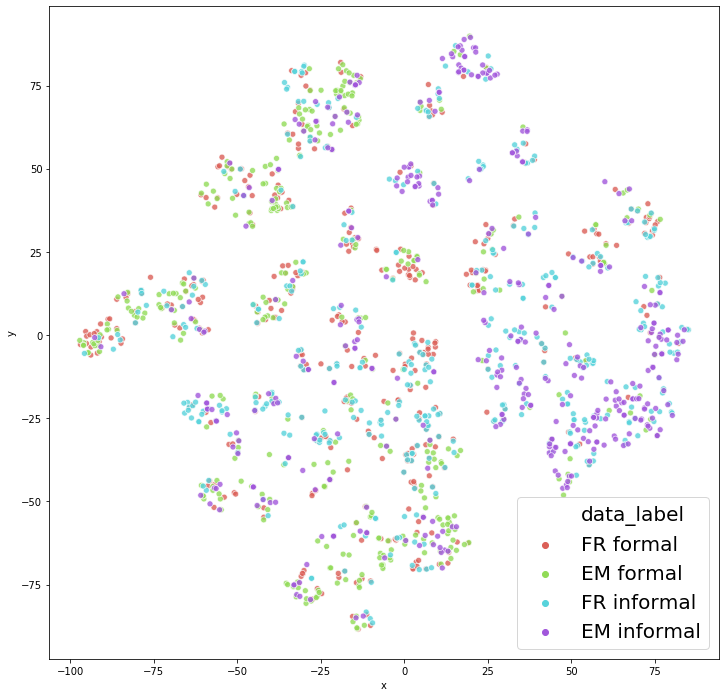

In [22]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="x", y="y",
    hue="data_label",
    palette=sns.color_palette("hls", 4),
    data=sub_tsne_df,
    legend="full",
    alpha=0.8
)
plt.legend(fontsize=20)
plt.show()

## Formality direction

In [0]:
FR_formal_tsne = tsne_df.loc[tsne_df.data_label == "FR formal"]
FR_informal_tsne = tsne_df.loc[tsne_df.data_label == "FR informal"].reset_index(inplace=False)

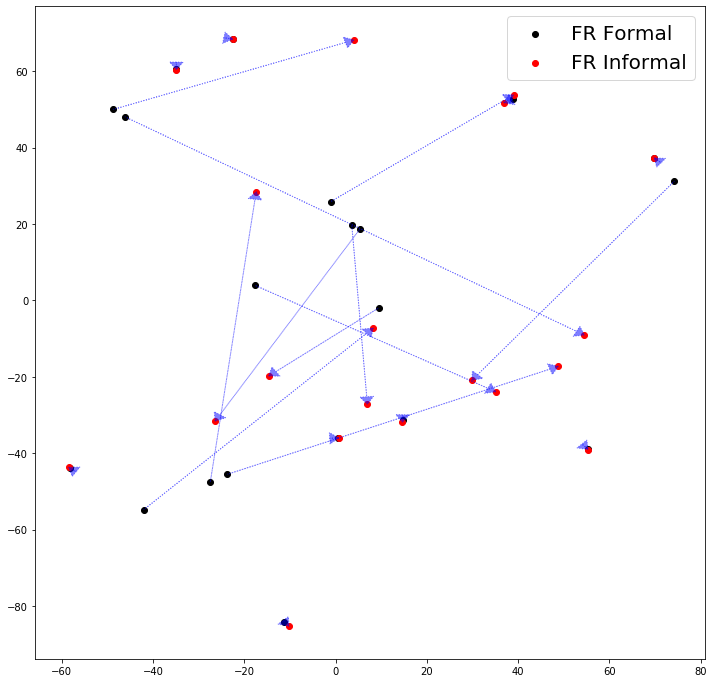

In [24]:
NUM_VECTORS = 20
x_formal = FR_formal_tsne['x'].values[:NUM_VECTORS]
y_formal = FR_formal_tsne['y'].values[:NUM_VECTORS]

x_informal = FR_informal_tsne['x'].values[:NUM_VECTORS]
y_informal = FR_informal_tsne['y'].values[:NUM_VECTORS]

x_direction = x_informal - x_formal
y_direction = y_informal - y_formal

plt.figure(figsize=(12,12))
plt.scatter(x_formal, y_formal, c="black")
plt.scatter(x_informal, y_informal, c="red")

for i in range(NUM_VECTORS):
  plt.arrow(x_formal[i], y_formal[i], x_direction[i], y_direction[i], head_width=3, head_length=2, length_includes_head=True, ls=':', color='blue', alpha=0.5)

plt.legend(['FR Formal', 'FR Informal'], fontsize=20)
plt.show()

# Changing formality in latent space

### Continously sampling between sentences

#### Sampling between different sentences

In [25]:
sentence1 = sp.decode_ids(data_dict["FR"]["train"]["formal"][42].tolist())
sentence2 = sp.decode_ids(data_dict["FR"]["train"]["informal"][19].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1, SEQ_LEN)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2, SEQ_LEN)

for i in range(0,6):
  k = i/5
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, SEQ_LEN)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


Sentence 1: are you hesitant to talk to them.
Sentence 2: call him & talk to him about it.
1.00 * sentence 1 + 0.00 * sentence 2 = are you hesitant to talk to them.
0.80 * sentence 1 + 0.20 * sentence 2 = are you hesitant to talk to them.
0.60 * sentence 1 + 0.40 * sentence 2 = talk to her about what she likes.
0.40 * sentence 1 + 0.60 * sentence 2 = go to mapquest and it should be there.
0.20 * sentence 1 + 0.80 * sentence 2 = call him and talk with him about it.
0.00 * sentence 1 + 1.00 * sentence 2 = call him and talk to him about it.


#### Sampling between formality in sentence pairs

In [27]:
sentence_num = 700
sentence1 = sp.decode_ids(data_dict["EM"]["train"]["formal"][sentence_num].tolist())
sentence2 = sp.decode_ids(data_dict["EM"]["train"]["informal"][sentence_num].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1, SEQ_LEN)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2, SEQ_LEN)

for i in range(0,6):
  k = i/5
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, SEQ_LEN)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


Sentence 1: the majority of the websites are starting with tamil.
Sentence 2: most of the websites starting with tamil
1.00 * sentence 1 + 0.00 * sentence 2 = the majority of my friends are men as well.
0.80 * sentence 1 + 0.20 * sentence 2 = the majority of my friends are mens.
0.60 * sentence 1 + 0.40 * sentence 2 = the newer questions on yahoo get more activity.
0.40 * sentence 1 + 0.60 * sentence 2 = the most expensive thing was the preacher...
0.20 * sentence 1 + 0.80 * sentence 2 = most of the websites starting with tamil
0.00 * sentence 1 + 1.00 * sentence 2 = most of the websites starting with tamil


### Adding mean formality

In [0]:
formal_embeds = np.array(FR_formal_embeds + EM_formal_embeds)
informal_embeds = np.array(FR_informal_embeds + EM_informal_embeds)
dirs = informal_embeds - formal_embeds
mean_dir = np.mean(dirs, axis=0).tolist()
var_dir = np.std(dirs, axis=0).tolist()

In [29]:
print(f"mean difference over all dims: {np.mean(mean_dir)}")
print(f"max variance over all dims: {np.mean(var_dir)}")

mean difference over all dims: 0.02638050893814696
max variance over all dims: 0.46754347580699485


In [30]:
sentence_num = 42
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: are you hesitant to talk to them.
target sentence: do u hesitate to talk to them?
unmoved recon: are you hesitant to talk to them.
moved recon: are you hesitant to talk to them.


In [31]:
sentence_num = 103
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: it sounds like 2 or 3 jobs.
target sentence: sounds like 2 or 3 jobs.
unmoved recon: it sounds like ridiclous head games.
moved recon: it sounds like ridiclous head games.


In [32]:
sentence_num = 124
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: good luck! you are going to need it!
target sentence: good luck your gonna need it!!
unmoved recon: good luck and let me know how it goes!
moved recon: good luck and let me know how it goes!


In [33]:
sentence_num = 300
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: i am dating a man who is amazing!
target sentence: ive been dating this guy who is amazing!
unmoved recon: i am in love with ray barnett!!!!
moved recon: i am in atlanta; will he travel?


In [34]:
sentence_num = 1124
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: am i going to believe in him?
target sentence: am i going to believe in him?
unmoved recon: am i going to be rich?
moved recon: am i going to read them?


In [35]:
sentence_num = 300
test_sentence = sp.decode_ids(data_dict["FR"]["train"]["formal"][sentence_num].tolist())
target_sentence = sp.decode_ids(data_dict["FR"]["train"]["informal"][sentence_num].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence, SEQ_LEN)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

test sentence: i am dating a man who is amazing!
target sentence: ive been dating this guy who is amazing!
unmoved recon: i am in love with ray barnett!!!!
moved recon: i am in atlanta; will he travel?
